In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/demand-forecasting-kernels-only/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/test.csv
/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv


In [79]:
sales_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', index_col = 0)
sales_test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv',index_col = 1)
sales_train.index = pd.to_datetime(sales_train.index)
sales_test.index = pd.to_datetime(sales_test.index)
display(sales_train.sample(10))
display(sales_test.sample(10))

,store,item,sales
date,,,
2016-02-28,10,5,16
2015-03-07,9,18,71
2017-06-05,6,7,48
2015-01-19,1,20,27
2017-06-20,7,34,18
2014-09-11,9,24,91
2016-03-16,7,34,30
2014-10-03,3,38,109
2016-09-29,6,17,29


,id,store,item
date,,,
2018-02-17,34427,3,39
2018-02-19,44689,7,50
2018-01-16,39615,1,45
2018-02-10,9850,10,11
2018-01-27,32426,1,37
2018-03-25,18713,8,21
2018-01-20,2449,8,3
2018-02-20,18500,6,21
2018-02-20,34250,1,39


In [80]:
display(sales_train.describe())

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet # Will have to see if I am even gonna use it

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as sts
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import tensorflow as tf

from itertools import product
from tqdm import tqdm_notebook
import itertools

import warnings

## Visualizing Sales & their Properties

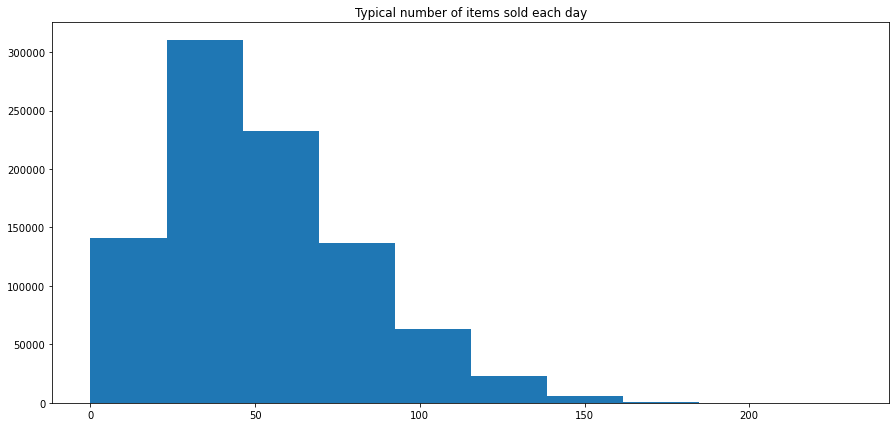

In [82]:
# To infer the typical number of items sold each day
plt.figure(figsize = (15,7))
plt.hist(sales_train['sales'], bins = 10)
plt.title('Typical number of items sold each day')
plt.show()

Before filter: (913000, 3)
After filter: (1826, 3)


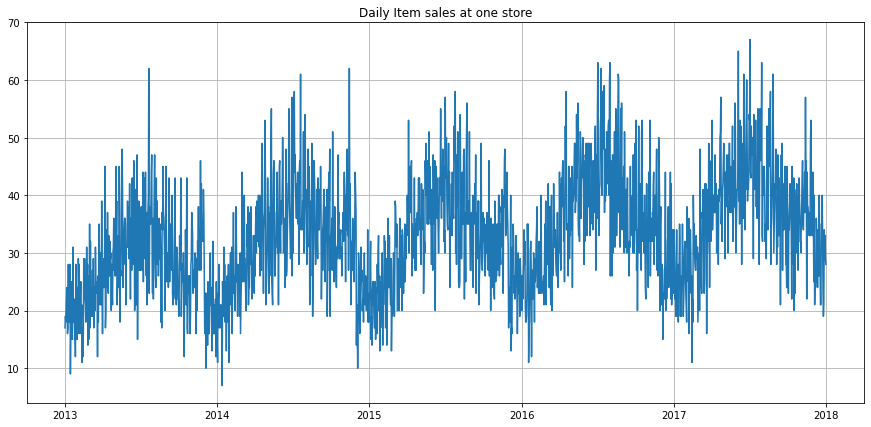

In [83]:
store_item_df = sales_train.copy()
# First, let us filterout the required data
store_id = 10   # Some store
item_id = 40    # Some item
print('Before filter:', store_item_df.shape)
store_item_df = store_item_df[store_item_df.store == store_id]
store_item_df = store_item_df[store_item_df.item == item_id]
print('After filter:', store_item_df.shape)
#display(store_item_df.head())

plt.figure(figsize = (15,7))
plt.plot(store_item_df.index, store_item_df.sales)
plt.grid(True)
plt.title('Daily Item sales at one store')
plt.show()

sales                                                        ...  \
item          1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2013-09-08  1386  3580  2232  1348  1192  3597  3596  4778  3087  4459  ...   
2016-10-30  1754  4651  2947  1717  1448  4752  4559  6173  4164  5777  ...   
2014-12-28  1071  2963  1815  1096   876  2816  2870  3636  2498  3573  ...   
2014-03-30  1500  4017  2414  1537  1308  4054  4114  5324  3528  5170  ...   
2014-08-24  1703  4384  2705  1664  1412  4476  4416  5795  3823  5610  ...   
2014-09-28  1476  3863  2409  1579  1205  3817  4024  5145  3425  4923  ...   
2017-03-19  1478  4078  2634  1624  1335  4168  4070  5473  3764  5239  ...   
2013-01-13   865  2427  1452   867   701  2309  2376  3073  2096  2837  ...   
2016-07-10  2112  5617  3529  2081  1817  5706  5734  7525  4967  7094  ...   
2014-04-13  1523  4195  2593  1614  1317  4238  4194  5463  3589  5169  ...   

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2013-09-08  1340  2203  3245  1830  5092  3507  1350  3154  1807  3996  
2016-10-30  1738  2970  4018  2384  6578  4632  1748  4221  2345  5133  
2014-12-28  1055  1800  2563  1399  4014  2892  1037  2429  1397  3103  
2014-03-30  1572  2612  3663  2061  5586  4035  1491  3561  1991  4540  
2014-08-24  1647  2760  3852  2217  6105  4525  1627  3801  2198  5047  
2014-09-28  1542  2486  3382  1979  5413  3890  1439  3431  2011  4366  
2017-03-19  1535  2556  3704  2083  5802  4195  1560  3774  2143  4696  
2013-01-13   839  1515  2014  1226  3177  2280   872  1964  1118  2659  
2016-07-10  2084  3636  4958  2829  7907  5647  2119  4931  2916  6191  
2014-04-13  1533  2611  3614  2066  5585  4099  1482  3686  2071  4757  

[10 rows x 50 columns]

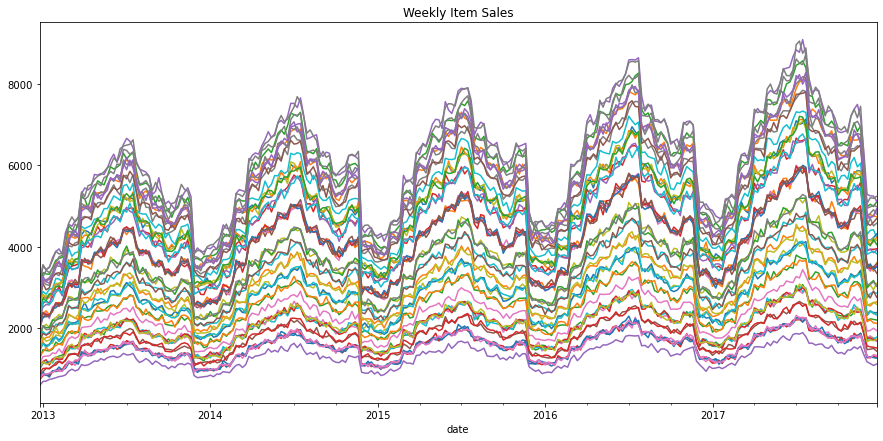

In [84]:
# The daily sales values seem very sporadic, we are now gonna plot the sum value of sales over a week
stores_sales_df1 = sales_train.copy()
stores = pd.DataFrame(stores_sales_df1.groupby(['date', 'item']).sum()['sales']).unstack()
stores = stores.resample('W',label='left').sum()
stores.sort_index(inplace = True)

display(stores.sample(10))

stores.plot(figsize=(15,7), title='Weekly Item Sales', legend=None)
plt.show()

sales                                                          \
store          1      2      3      4      5      6      7      8      9    
date                                                                        
2015-12-27  12156  17405  15310  14561  10461  10296   9365  16842  14105   
2017-12-10  14149  19913  17754  16475  11831  11646  10716  18894  16340   
2016-03-27  17686  25036  22057  20062  14680  14782  13537  23372  20371   
2013-05-19  15920  22125  19544  18259  13164  13012  12027  21284  18135   
2016-03-13  16122  23024  20684  18879  13552  13570  12539  22173  18886   
2017-08-06  20960  30051  26563  24605  17860  17766  16228  28514  24578   
2013-09-15  14549  20655  18361  16797  12427  12233  11272  19850  17206   
2013-02-24  11306  16266  14160  13371   9617   9688   8730  15507  13135   
2015-01-11  11126  15996  14055  12959   9432   9317   8819  15361  12996   
2015-02-15  12355  17908  15860  14495  10435  10440   9555  17224  14330   

                   
store          10  
date               
2015-12-27  15388  
2017-12-10  17578  
2016-03-27  21864  
2013-05-19  19591  
2016-03-13  20233  
2017-08-06  26141  
2013-09-15  17994  
2013-02-24  14036  
2015-01-11  13945  
2015-02-15  15473

sales                                                         \
store          1      2      3      4      5      6     7      8      9    
date                                                                       
2012-12-30   8449  11713  10345   9650   6836   7117  6238  11107   9421   
2013-01-06   9289  13451  11869  10886   7884   7917  7273  12787  10887   
2013-01-13   9287  13264  11660  10760   7851   7894  7120  12791  10753   
2013-01-20   9229  13329  11888  10747   7822   7932  7277  12606  10922   
2013-01-27   9826  14058  12429  11585   8267   8305  7471  13346  11422   
2013-02-03  10281  14771  13005  12205   8574   8705  7932  14284  12005   
2013-02-10  10337  14941  13127  12177   8816   8722  7987  14085  12172   
2013-02-17  10425  14783  12976  12171   8750   8653  7983  13912  12010   
2013-02-24  11306  16266  14160  13371   9617   9688  8730  15507  13135   
2013-03-03  12614  17674  15759  14193  10492  10541  9548  16892  14433   

                   
store          10  
date               
2012-12-30  10191  
2013-01-06  11659  
2013-01-13  11570  
2013-01-20  11546  
2013-01-27  12318  
2013-02-03  12804  
2013-02-10  12897  
2013-02-17  13103  
2013-02-24  14036  
2013-03-03  15559

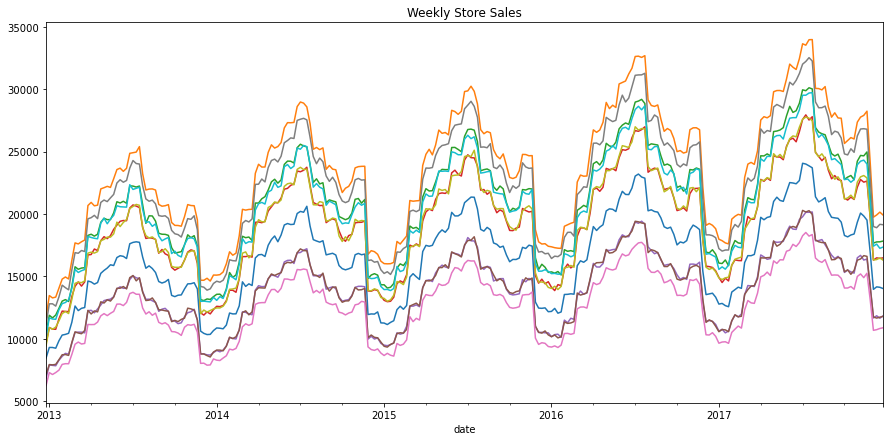

In [85]:
# The daily sales values seem very sporadic, we are now gonna plot the sum value of sales over a week
stores_sales_df = sales_train.copy()
stores = pd.DataFrame(stores_sales_df.groupby(['date', 'store']).sum()['sales']).unstack()
stores = stores.resample('W',label='left').sum()
stores.sort_index(inplace = True)

display(stores.sample(10))
display(stores.head(10))

stores.plot(figsize=(15,7), title='Weekly Store Sales', legend=None)
plt.show()

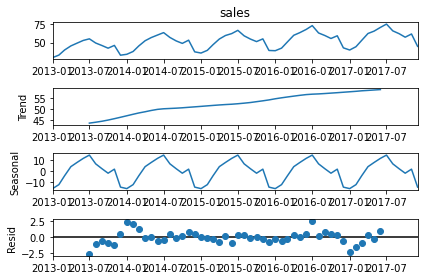

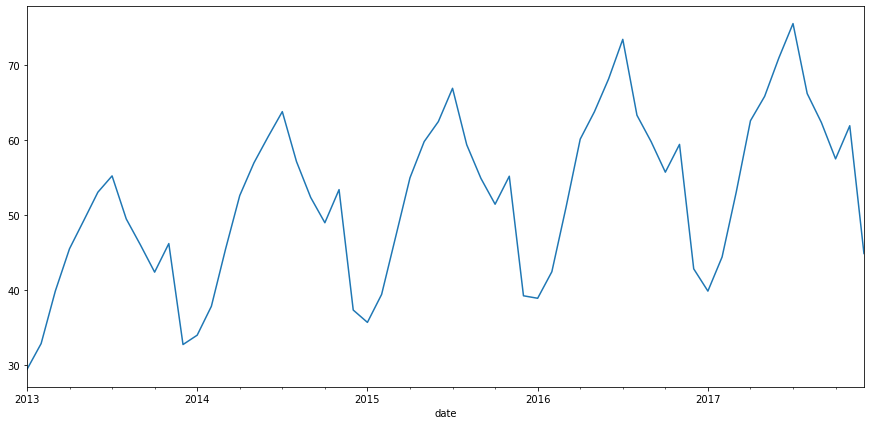

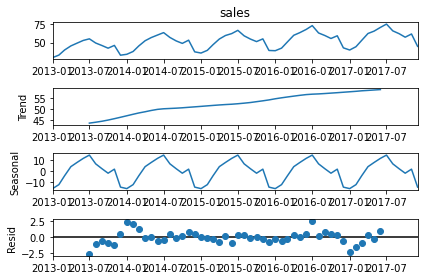

In [86]:
# Need to visualise the trends, seasonality and other features (on both additive and multiplicative scales) here.

date_sales = sales_train.drop(['store','item'], axis=1).copy() 
y = date_sales['sales'].resample('MS').mean() 
y['2017':] #sneak peak
y.plot(figsize=(15, 7))

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()

# Still have to make sense of the plots and describe it, also, need to try and plot these components on a weekly basis, but on a smaller time scale as well (Say 3 months).

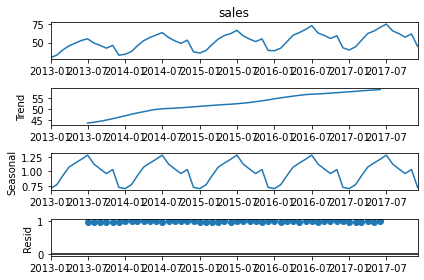

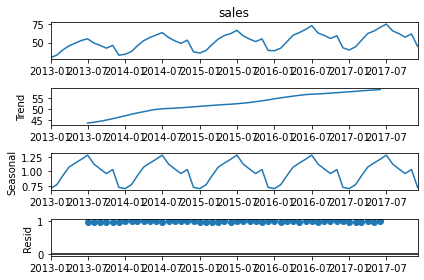

In [87]:

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot()

### Supporting Functions
These functions will be used to assist creation of data, to implement loss metrics that aren't implicit in scipy library, and a module to plot the results

In [88]:
def create_data(df, store_id, item_id):
    '''
    This function creates a series containing the sales values of a particular item of a particular store (as prescribed in the argument values). This will return a pandas dataframe
    with datetime index.
    
    Args:
        df (dataframe) -> A multiindex dataframe containing store, item, and dates as index
        store_id (integer) -> The id of the store
        item_id (integer) -> The item number
    
    '''
    series = df.loc[(store_id,item_id,slice(None)),:]
    series_df1 = series.reset_index(['store', 'item'])
    new_series = series_df1.drop(['store', 'item'], axis = 1)
    new_series.index = pd.to_datetime(new_series.index)
    return new_series


def mean_absolute_percentage_error(y_true, y_pred, multioutput = 'raw_values'):
    '''
    This function returns the mean absolute percentage error of the values in form of a numpy array, if the multoutput is set to 'raw_values', and returns a single float value of 
    the average of loss, if the multioutput is set to 'uniform_average'
    
    Args:
        y_true (iterable) -> Representing the actual values of the output
        y_pred (iterable) -> Representing the predicted values of the output
        multioutput (string) -> Could either be 'raw_values', or 'uniform_average'
        
    Returns:
        A numpy array or a single float value depending on the multioutput argument.
    '''
    if multioutput == 'raw_values':
        return np.divide(np.abs(y_true - y_pred), np.abs(y_true)) * 100
    if multioutput == 'uniform_average':
        return np.mean(np.divide(np.abs(y_true - y_pred), np.abs(y_true)) * 100)

def total_error(actual_value, pred_value, metric):
    '''
    This function returns the total error of the predicted values when evaluated against the actual values. It returns a single float variable representing that error
    
    '''
    if metric<0 or metric>4:
        raise ValueError('The loss metric should be between 1 and 4, included')
    if metric == 0:
        error_term = mean_absolute_error(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 1:
        error_term = mean_squared_error(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 2: 
        error_term = mean_absolute_percentage_error(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 3:
        error_term = r2(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 4:
        error_term = smape(actual_value, pred_value, multioutput = 'uniform_average')
    return error_term
    



In [89]:
def smape(y_pred, y_true, multioutput = 'raw_values'):
    '''
    This function returns the symmetric mean absolute percentage error of the values in form of a numpy array, if the multoutput is set to 'raw_values', and returns a single float value of 
    the average of loss, if the multioutput is set to 'uniform_average'
    The formula for SMAPE has been defined here - https://www.forecastpro.com/Trends/forecasting101August2011.html
    
    Args:
        y_true (iterable) -> Representing the actual values of the output
        y_pred (iterable) -> Representing the predicted values of the output
        multioutput (string) -> Could either be 'raw_values', or 'uniform_average'
        
    Returns:
        A numpy array or a single float value depending on the multioutput argument.
        
    '''
    if multioutput == 'raw_values':
        return np.divide(np.abs(y_true - y_pred), np.abs((y_true + y_pred)/2) * 100)
    else:
        return np.mean(np.divide(np.abs(y_true - y_pred), np.abs((y_true + y_pred)/2)) * 100)
    

In [90]:
# Also, I need to define seperate plotting functions for each of the models becuase the predictions they make won't necessarily have actual values corresponding to them 
# and we will have to use particular plot methods for each of those methods (for eg, triple exponential smoothing can be predicted using brutlag method)

def plot_results(pred_value, actual_value, plot_intervals = False, scale = 2, plot_anomalies = False, metric = 4, pred_start = -1):
    '''
    This function plots the results of a time series prediction. It can also plot the intervals and anomalies, if so directed.
    
    Args:
        pred_value (iterable) -> Integer values of the predicted values of series
        actual_value (iterable) -> Integer values of the actual values of the series
        plot_intervals (boolean) -> Decides if the lower and upper bounds are to be plotted.
        plot_anomalies (boolean) -> Decides if the anomalies are to be plotted.
        scale (float) -> An hyperparameter for interval deduction.
        metric (integer) -> To decide the loss metric to be used
            0 - MAE
            1 - MSE
            2 - MAPE
            3 - R2
            4 - SMAPE
        pred_start (integer) -> A negative integer referring to the number of time steps that have been used as test data. 
        
    '''
    
    plt.figure(figsize = (15,7))
    plt.title('Prediction values for sales')
    plt.plot(pred_value, "g", label = "Predicted values")
    
    # Plot the confidence intervals of the smoothed values
    if plot_intervals:
        if metric<0 or metric>4:
            raise ValueError('The loss metric should be between 1 and 4, included')
        if metric == 0:
            error_term = mean_absolute_error(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 1:
            error_term = mean_squared_error(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 2: 
            error_term = mean_absolute_percentage_error(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 3:
            error_term = r2(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 4:
            error_term = smape(actual_value, pred_value, multioutput = 'raw_values')
        deviation = np.std(actual_value - pred_value)
        lower_bound = pred_value - (error_term + scale*deviation)
        upper_bound = pred_value + (error_term + scale*deviation)
        plt.plot(upper_bound, "r--", label = "Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index = actual_value.index, columns = actual_value.columns)
            anomalies[actual_value<lower_bound] = actual_value[actual_value<lower_bound]
            anomalies[actual_value>upper_bound] = actual_value[actual_value>upper_bound]
            plt.plot(anomalies, "ro", makersize = 1)
        
    plt.plot(actual_value, label = "Actual Values")
    plt.axvspan(len(actual_value) + pred_start, len(actual_value), alpha = 0.6, color = 'grey')
    plt.legend(loc = "upper left")
    # See if the total error term can be added to the plot (to compare the results of different models and different evaluation metrics)
    plt.grid(True)
    plt.show()
        
        

## Exponential Smoothing
The problem with exponential smoothing is that we can't use it to predict the trends of the data for very long periods (6 months in our case), and this limits the utility of this model, nonetheless, this can be used to make a naive prediction on a short term basis and serves as as a good estimate of a conservative prediction which can then be used to compare the volatility and credibility of the predictions made by our long term predictions. Think of it this way, if we were to make predictions for, lets say stock prices, and there is and a certain incident that causes the time series to behave unusually (like a chain of events set in motion due to some scandal or something), then we would want our model to quickly adopt itself to the new environment it has found itself in. Of course, there won't be enough data of such cataclysmic changes to make meaningful long term predictions, and in those scenarios, a manually tuned expectancy value derived from Exponential Smoothing will prove itself to be extremely useful.

#### Smoothing parameters
We will try and find the values of the smoothing parameters by passing the input values through a truncated conjugate gradient optmisation algorithm. This will help us ensure that we aren't just tuning those hyperparameters by ourselves, instead they are being set on a formal basis of how beneficial they are to the learning process.

In [91]:
class Single_ES:
    
    """
    This model object will produce the Single Exponential smoothing values. Since it does not have the abilities to either smooth or to add trend, it can only be used to make a single 
    meaningful prediction. That is, just one time step can be predicted.
    Args:
        series (iterable) -> Actual time series
        alpha (float) -> Represents the parameter for single exponential smoothing
        scaling_factor (float) -> sets the width of the confidence interval
        
    Returns:
        result (iterable) -> A numpy array containing the results of smoothing
    
    """
    
    
    def __init__(self, series, alpha = 0.9, scaling_factor=2):
        self.series = series
        self.alpha = alpha
        # Scaling factor will only be used, if the plot is done here in this class
        self.scaling_factor = scaling_factor
        
          
    def single_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.result = [series[0]] # first value is same as series
        for t in range(1, len(series)):
            self.result.append(self.alpha * self.series[t] + (1 - self.alpha) * self.result[t-1])
        # Since we can't make more than one prediction, we can either print the plot here, or we can print the plot from the calling function where the 'model' object is created. 
        # There's no difference in the plots drawn from either.
        return np.array(self.result)

In [92]:
class Double_ES:
    
    """
    This class performs double exponential smoothing and updates the deviation, upper bound, and lower bound values for each time step. It also plots the results with its own function.
    There is no limit to the prediction horizon, however, since we are only relying on the trend update to make the predictions, it wouldn't be wise to set the n_preds value to be too 
    large.
    
    Args:
        series (iterable) -> Actual values array
        alpha, beta (float) -> Double exponential smoothing parameters
        n_preds (int) -> predictions horizon
        scaling_factor (float) - sets the width of the confidence interval and is used to determine the upper bound and lower bound
    
    """
    
    
    def __init__(self, series, alpha, beta, n_preds, scaling_factor=1):
        if type(series) is np.ndarray:
            series = pd.DataFrame(series)
        self.series = series
        self.alpha = alpha
        self.beta = beta
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(len(self.series)-1):
            sum += float(self.series.iloc[i+1] - self.series.iloc[i])
        return sum /(len(self.series))

          
    def double_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series.iloc[0]
                trend = self.initial_trend()
                self.result.append(self.series.iloc[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                
                self.PredictedDeviation.append(0)
                
                # Can't decide if I should add the error term (as I did in plot_results() function), into the evaluation of upper and lower bounds. I will have to rewrite that 
                # entire function here, and take metric as an argument as well. Will have to see the plot, to figure out if I should.
                self.UpperBound.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                
                # We could apply smoothing to the 'm*trend' part of the code in the next line, it will ensure that the function isn't running just on final trend value, but is 
                # also considering the trend values of the earlier time steps. Will have to see the results to alter this part.
                self.result.append(smooth + m*trend)
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series.iloc[i]
                last_smooth, smooth = smooth, self.alpha*(val) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                self.result.append(smooth+trend)
                
                # Instead of calculating the standard deviation of the results, we will here calculate the deviation using a variant of brutlag method, with the only difference being,
                # instead of using gamma as the parameter for deviation updata, we will use a fixed value of 0.5 (which we can adjust according to the results)
                self.PredictedDeviation.append(0.5 * np.abs(self.series.iloc[i] - self.result[i]) 
                                               + (1- 0.5)*self.PredictedDeviation[-1])
            
            # Again, the error term can be added here (to grant the model more versatility)
            self.UpperBound.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBound.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)

        
    def plot_Double_ES(self, test_data, plot_intervals = True, plot_anomalies = True, aggregated = True):
        '''
        Function plots the results for DES. It can plot the results, lower bound, and upper bound even for time steps that do not have actual values given.
        This plot function is more geared towards the actual industry situations where we are deploying the model for predictions without having the 'actual observed values' given.
        
        args:
            test_data (dataframe) -> Dataframe representing the last 180 values indexed according to their date time index values
            plot_intervals (boolean) -> Defines if we want to plot the confidence intervals
            plot_anomalies (boolean) -> Defines if we want to plot the anomalies
            aggregated (boolean) -> Determines whether or not we want to resample our plots on a weekly basis
        
        '''
        self.result = pd.DataFrame(np.array(self.result))
        any_df = pd.concat([self.series, test_data], axis = 0)
        self.result.index = pd.to_datetime(any_df.index)
        t = self.series.index
        l = len(self.series)
        self.series = pd.concat([self.series, test_data], axis = 0)
        
        if plot_intervals:
            self.UpperBound = pd.DataFrame(self.UpperBound)
            self.UpperBound.index = self.result.index
            self.LowerBound = pd.DataFrame(self.LowerBound)
            self.LowerBound.index = self.result.index
            
        if plot_anomalies:
            self.anomalies = np.array([np.NaN]*l)
            self.anomalies = pd.DataFrame(self.anomalies)
            self.anomalies.index = t
            drop_list = []
            
            for i in range(len(self.anomalies)):
                if self.series.values[i][0] < self.LowerBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                if self.series.values[i][0] > self.UpperBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                else:
                    drop_list.append(i)
            
            self.anomalies.drop(self.anomalies.index[drop_list], axis = 0, inplace = True)
        
        # This part prints the results in an aggregated form and everything is resampled according to weekly basis
        if aggregated == True:
            results_aggregated = self.result.resample('W', label = 'left').sum()
            actual_aggregated = self.series.resample('W', label = 'left').sum()
            UpperBound_aggregated = self.UpperBound.resample('W', label = 'left').sum()
            LowerBound_aggregated = self.LowerBound.resample('W', label = 'left').sum()
            
            # The following code is to find aggregated anomalies. 
            l1 = len(results_aggregated)
            anomalies_aggregated = np.array([np.NaN]*l1)
            anomalies_aggregated = pd.DataFrame(anomalies_aggregated)
            anomalies_aggregated.index = results_aggregated.index
            drop_list1 = []
            for j in range(len(anomalies_aggregated)):
                if actual_aggregated.values[j][0] < LowerBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                if actual_aggregated.values[j][0] > UpperBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                else:
                    drop_list1.append(j)
            anomalies_aggregated.drop(anomalies_aggregated.index[drop_list1], axis = 0, inplace = True)

            plt.figure(figsize = (15,7))
            plt.plot(results_aggregated, "g", label ="Predicted Values")
            plt.plot(actual_aggregated, "b", label = "Actual Values")
            plt.plot(UpperBound_aggregated, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(LowerBound_aggregated, "r--")
            plt.fill_between(x = results_aggregated.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.4, color = "grey")
            plt.plot(anomalies_aggregated, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.grid(True)
            plt.legend(loc = "upper left")
            plt.show()
        
        # The following part prints the results without aggregation
        else:
            plt.figure(figsize = (15,7))
            plt.plot(self.result, "g", label = "Predicted Values")
            plt.title("Prediction values for sales using Triple Exponential Smoothing")
            plt.plot(self.series, "b", label = "Actual Values")
            plt.plot(self.UpperBound, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(self.LowerBound, "r--", alpha = 0.3)
            plt.fill_between(x = self.result.index, y1 = self.UpperBound.values.ravel(), y2 = self.LowerBound.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.6, color = 'grey')
            plt.plot(self.anomalies, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.show()       
        

In [93]:
class Triple_ES:
    
    """
    In Triple Exponential Smoothing, we implement the Holt-Winters model, and derive the outliers using the brutlag method
    
    Args:
        series (iterbale) -> Actual values array
        slen (int) -> Length of a season
        alpha, beta, gamma (float) -> Holt-Winters model coefficients
        n_preds (int) -> predictions horizon
        scaling_factor (float) -> sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, alpha, beta, gamma, n_preds = 180, scaling_factor=1.5, slen = 365):
        if type(series) is np.ndarray:
            series = pd.DataFrame(series)
        self.series = series
        self.slen = int(slen)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series.iloc[i+self.slen] - self.series.iloc[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append((self.series.iloc[self.slen*j:self.slen*j+self.slen].sum()[0])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series.iloc[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series.iloc[0]
                trend = self.initial_trend()
                self.result.append(self.series.iloc[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBound.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series.iloc[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series.iloc[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBound.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBound.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

    
    
    def plot_Triple_ES(self, test_data, plot_intervals = True, plot_anomalies = True, aggregated = True):
        '''
        Function plots the results for TES. It can plot the results, lower bound, and upper bound even for time steps that do not have actual values given.
        This plot function is more geared towards the actual industry situations where we are deploying the model for predictions without having the 'actual observed values' given.
        
        args:
            test_data (dataframe) -> Datetime index wise representation of the last 180 day values.
            plot_intervals (boolean) -> Defines if we want to plot the confidence intervals
            plot_anomalies (boolean) -> Defines if we want to plot the anomalies
            aggregated (boolena) -> Decides whether or not we want to resample our output on a weekly basis
        
        '''
        self.result = pd.DataFrame(self.result)
        any_df = pd.concat([self.series, test_data], join = "inner", axis = 0)
        self.result.index = pd.to_datetime(any_df.index)
        t = self.series.index
        l = len(self.series)
        self.series = pd.concat([self.series, test_data], axis = 0)
        #display(self.series.tail(20))
        #display(test_data.tail(20))
        #display(self.result)
        
        if plot_intervals:
            self.UpperBound = pd.DataFrame(self.UpperBound)
            self.UpperBound.index = self.result.index
            self.LowerBound = pd.DataFrame(self.LowerBound)
            self.LowerBound.index = self.result.index

        if plot_anomalies:
            self.anomalies = np.array([np.NaN]*(l))
            self.anomalies = pd.DataFrame(self.anomalies)
            self.anomalies.index = t
            drop_list = []
            
            for i in range(len(self.anomalies)):
                if self.series.values[i][0] < self.LowerBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                if self.series.values[i][0] > self.UpperBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                else:
                    drop_list.append(i)
            
            self.anomalies.drop(self.anomalies.index[drop_list], axis = 0, inplace = True)
            
        # This part prints the results in an aggregated form and everything is resampled according to weekly basis
        if aggregated == True:
            results_aggregated = self.result.resample('W', label = 'left').sum()
            actual_aggregated = self.series.resample('W', label = 'left').sum()
            UpperBound_aggregated = self.UpperBound.resample('W', label = 'left').sum()
            LowerBound_aggregated = self.LowerBound.resample('W', label = 'left').sum()
            
            # The following code is to find aggregated anomalies. 
            l1 = len(results_aggregated)
            anomalies_aggregated = np.array([np.NaN]*l1)
            anomalies_aggregated = pd.DataFrame(anomalies_aggregated)
            anomalies_aggregated.index = results_aggregated.index
            drop_list1 = []
            for j in range(len(anomalies_aggregated)):
                if actual_aggregated.values[j][0] < LowerBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                if actual_aggregated.values[j][0] > UpperBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                else:
                    drop_list1.append(j)
            anomalies_aggregated.drop(anomalies_aggregated.index[drop_list1], axis = 0, inplace = True)
            

            plt.figure(figsize = (15,7))
            plt.plot(results_aggregated, "g", label ="Predicted Values")
            plt.plot(actual_aggregated, "b", label = "Actual Values")
            plt.plot(UpperBound_aggregated, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(LowerBound_aggregated, "r--")
            plt.fill_between(x = results_aggregated.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.4, color = "grey")
            plt.plot(anomalies_aggregated, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.grid(True)
            plt.legend(loc = "upper left")
            plt.show()
        
        # The following part prints the results without aggregation
        else:
            plt.figure(figsize = (15,7))
            plt.plot(self.result, "g", label = "Predicted Values")
            plt.title("Prediction values for sales using Triple Exponential Smoothing")
            plt.plot(self.series, "b", label = "Actual Values")
            plt.plot(self.UpperBound, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(self.LowerBound, "r--", alpha = 0.3)
            plt.fill_between(x = self.result.index, y1 = self.UpperBound.values.ravel(), y2 = self.LowerBound.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.6, color = 'grey')
            plt.plot(self.anomalies, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.show()

In [94]:
# This cell is to include the data preparation part, where we do the train test split on a rolling basis. This function will be called by the proceeding optimization function.

def desCVscore(params, series, loss_function=mean_squared_error):
    """
        Returns error on CV  and thereby helps decide the best parameters for Double Exponential Smoothing
        
        Args:
        
            params -> vector of parameters for optimization
            series -> dataset with timeseries
        
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=9) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = Double_ES(series=values[train], alpha=alpha, beta=beta, n_preds=len(test))
        model.double_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [95]:
def tesCVscore(params, series, loss_function=mean_squared_error, slen=365):
    """
        Returns error on CV  and thereby helps decide the best parameters for Triple Exponential Smoothing
        
        Args:
            params -> vector of parameters for optimization
            series -> dataset with timeseries
            slen -> season length for Triple Exponential Smoothing model. Here the season length is obviously 365.
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=9) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = Triple_ES(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [96]:
def des_forecast(train_data, test_data):
    '''
    
    
    
    '''
    #Initializing model parameters, alpha and beta
    x_des = [0,0]

    # Minimizing the loss function. Still have to figure out a way to use MAPE loss function in this metric as well
    #opt_des = minimize(desCVscore, x0 = x_des, args = (train_data, mean_squared_error), method = "TNC", bounds = ((0,1), (0,1)))

    # Finding optimal parameter values
    #alpha, beta = opt_des.x
    alpha = 0.90
    beta = 0.001
    print("Alpha value is: ", alpha)
    print("Beta value is:", beta)

    # Now we train the model with these values of alpha and beta
    model_des = Double_ES(train_data, alpha, beta, n_preds = 180, scaling_factor = 1)
    model_des.double_exponential_smoothing()
    model_des.plot_Double_ES(test_data, plot_intervals = True, plot_anomalies = True)
    anomalies_des = model_des.anomalies
    result_des = model_des.result
    error_des = total_error(test_data.values.ravel(), result_des[-180:].values.ravel(), 1)
    print("The total error using mean squared error is", error_des)
    display(anomalies_des)
    return result_des, anomalies_des

In [97]:
def tes_forecast(train_data, test_data):
    '''
    
    
    
    
    '''
    # Initializing model parameters, alpha and beta and gamma
    x_tes = [0,0,0]

    # Minimizing the loss function. Still have to figure out a way to use SMAPE loss function in this metric as well
    #opt_tes = minimize(tesCVscore, x0 = x_tes, args = (train_data, mean_squared_error), method = "TNC", bounds = ((0,1), (0,1),(0,1)))

    # Finding optimal parameter values
    #apha, beta, gamma = opt_tes.x
    alpha = 0.9
    beta = 0.0001
    gamma = 0.9
    print("Alpha value is: ", alpha)
    print("Beta value is:", beta)
    print("Gamma Value is : ", gamma)

    # Now we train the model with these values of alpha, beta and gamma
    
    model_tes = Triple_ES(train_data, alpha, beta, gamma, slen = 365, n_preds = 180, scaling_factor = 0.9)
    model_tes.triple_exponential_smoothing()
    model_tes.plot_Triple_ES(test_data, plot_intervals = True, plot_anomalies = True)
    anomalies_tes = model_tes.anomalies
    result_tes = model_tes.result
    error_tes = total_error(test_data.values.ravel(), result_tes[-180:].values.ravel(), 1)
    #UpperBound_tes = model_tes.UpperBound
    #LowerBound_tes = model_tes.LowerBound
    display(anomalies_tes)
    print("The total error using mean squared error is", error_tes)
    #display(result_tes[-180:])
    #display(test_data)
    #total_data = pd.concat([train_data, test_data], axis = 0)
    
    return result_tes, anomalies_tes


### Actual Implementation of Exponential Smoothing

Alpha value is:  0.9
Beta value is: 0.001


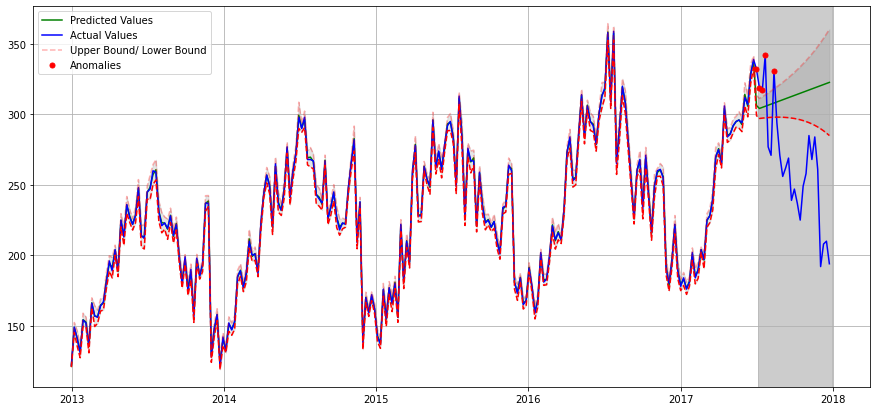

The total error using mean squared error is 137.129052890367


,0
date,
2013-01-02,19.0
2013-01-04,21.0
2013-01-05,23.0
2013-01-09,28.0
2013-01-12,24.0
...,...
2017-06-17,61.0
2017-06-21,47.0
2017-06-23,53.0


Alpha value is:  0.9
Beta value is: 0.0001
Gamma Value is :  0.9


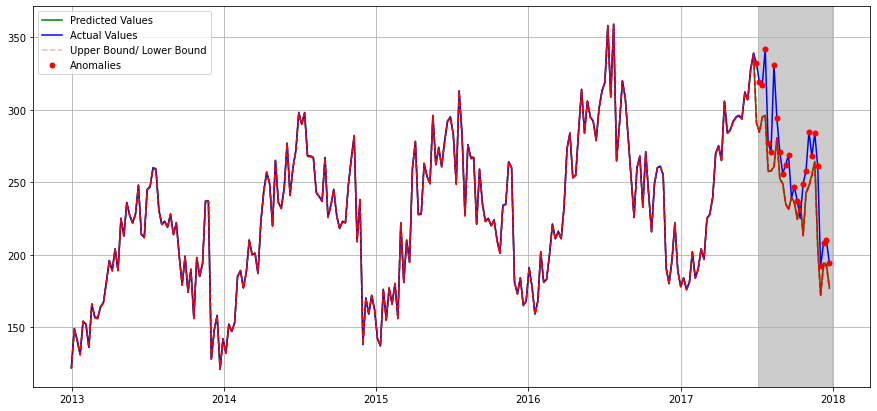

,0
date,
2013-01-02,19.0
2013-01-05,23.0
2013-01-06,24.0
2013-01-09,28.0
2013-01-12,24.0
...,...
2017-06-21,47.0
2017-06-23,53.0
2017-06-29,43.0


The total error using mean squared error is 86.13996624336131


In [98]:
# This cell will include the main wrapper part of the code, which will first call the data creation function followed by a call to the optimization function to derive the parameter values, and then will create objects for each of the
# three types of ES models, and produce the results, then use those objects to call the plot function of TES and DES. Here, I will also write 
# the code for identifying the anomalies by calling the necessary functions. 

store_chain_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
storewise_train = store_chain_train.set_index(['store', 'item', 'date'])

#The following part can be put into a loop for all stores and all items. I won't be doing it for now
store_id = 10     #Random store id
item_id = 40      # Random item id
series_data = create_data(storewise_train, store_id, item_id)
train_data = series_data.iloc[:-180]
test_data = series_data.iloc[-180:]
#display(train_data)
#display(test_data)


# The following code is for Double Exponential Smoothing. The function defintion des_forecast is to house the following code
results_des, anomalies_des = des_forecast(train_data, test_data)
#plot_results(results_des, series_data, plot_intervals = True, scale = 2, plot_anomalies = True, metric = 4, pred_start = -180)


# The following code is for Triple Exponential Smoothing.
results_tes, anomalies_tes = tes_forecast(train_data, test_data)
#plot_results(results_tes, series_data, plot_intervals = False, scale = 2, plot_anomalies = False, metric = 4, pred_start = -180)





## SARIMA Modelling
* We will check for stationarity first using Augmented Dickey Fuller test
* Then, we will remove trend and seasonality to make the sales data stationary
* Then, identify the p, d, q values (Parameters for ARIMA) using the SARIMAX optimization function
* Then, we fit the SARIMA model using the metrics thus defined

In [99]:
# Here we will create a weekly aggregated version of our time series. We will be testing our results on both these TS
store_id = 10
item_id = 40
sales_df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
sales_df = sales_df.set_index(['store','item','date'])
sales_df = create_data(sales_df, store_id, item_id)
sales_df_train = sales_df.iloc[:-180]
sales_df_test = sales_df.iloc[-180:]
sales_df_agg = sales_df.resample('W', label = 'left').sum()
sales_df_agg_train = sales_df_agg.iloc[:-26]
sales_df_agg_test = sales_df_agg.iloc[-26:]
#display(sales_df.head(10))
#display(sales_df_agg.head(10))
#display(sales_df.describe())
#display(sales_df_agg.describe())

### 1. Check For stationarity

In [100]:
def test_stationarity(y, lags=None):
    '''
        This function will plot the time series, its ACF and PACF, & calculate Augmented Dickey–Fuller test
        
        y (DataFrame) -> Actual sales timeseries. With 'sales' as the only column
        lags (integer) -> Indicates the number of lags to include in ACF, PACF calculation
    '''
    #if not isinstance(y, pd.Series):
        #y = pd.Series(y, index = ['sales'])
        
   
    fig = plt.figure(figsize=(15,7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=ts_ax)
    adf_test = adfuller(y.sales, autolag = 'AIC')
    adf_output = pd.Series(adf_test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    display(adf_output)
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(adf_output[1]))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

Test Statistic                   -2.310695
p-value                           0.168542
#Lags Used                       20.000000
Number of Observations Used    1625.000000
dtype: float64

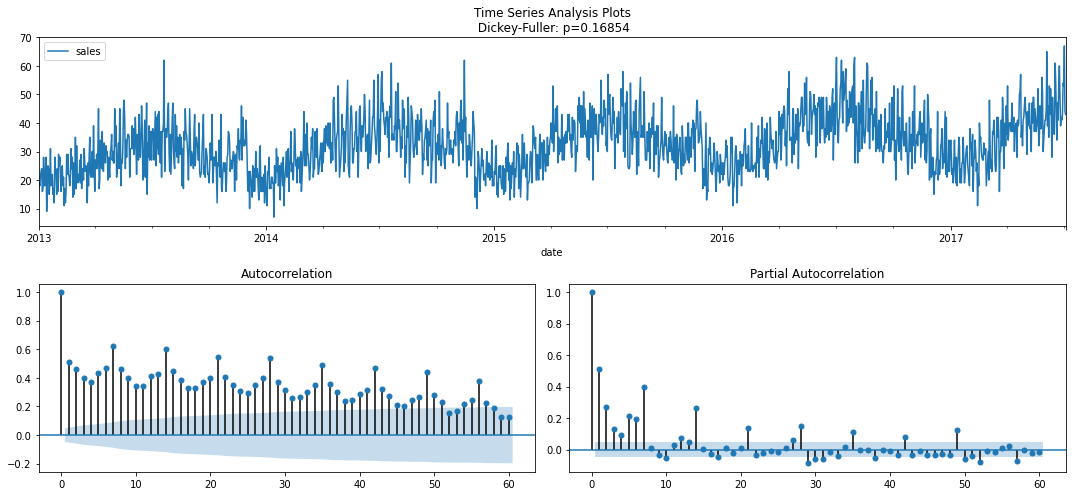

In [101]:
test_stationarity(sales_df_train, lags = 60)

### 2. Remove Non Stationarity
Since the Dickey Fuller statistic isn't big enough to reject the null hypothesis - presence of a unit root, we therefore conclude the series is not stationary, and there is some trend in the series, along with seasonality (as is obvious from the plot). 
Check out acceptable test statistic scores for rejecting null hypothesis at - https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/

I will try:
* Differencing to remove trend and seasonality.
* If trend isn't removed even by differencing, then I will try a bit of smoothing

Test Statistic                   -5.530348
p-value                           0.000002
#Lags Used                       20.000000
Number of Observations Used    1260.000000
dtype: float64

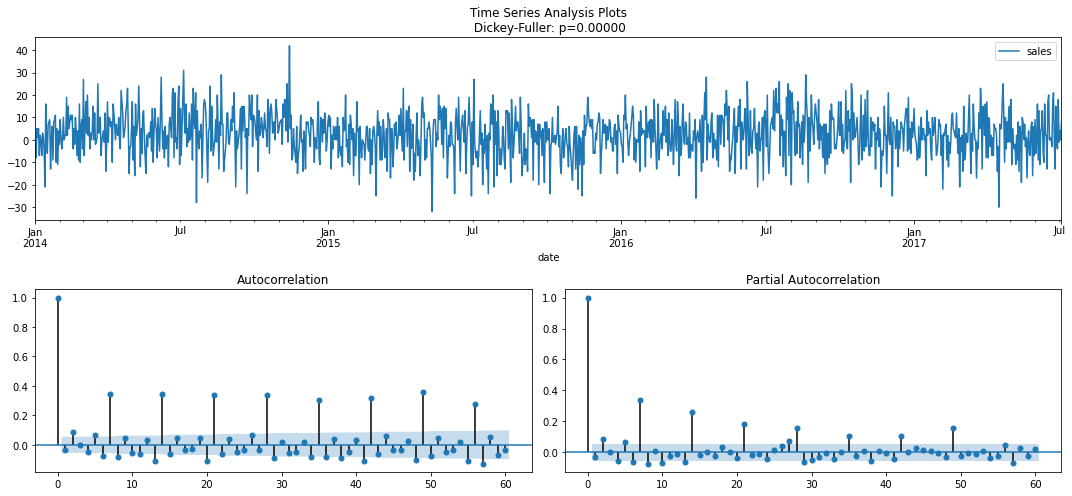

In [102]:
# Here we will try to remove non stationarity by removing seasonality. We can see the season is an year -> 365 days.
sales_df_train_diff1 = sales_df_train - sales_df_train.shift(365)
test_stationarity(sales_df_train_diff1.iloc[365:], lags = 60)

*While the dickey fuller value does not indicate the presence of a unit root, the plot above indicates a slight correlation within the lag values on a weekly basis (Notice the consistent high value on ACF plot on every 7th day). This makes sense as well, sales data is should (probably) show a weekly cycle. This could perhaps be eased out by 1st order differencing with a lag of 7 (to represent a week)*

Test Statistic                -1.133514e+01
p-value                        1.088373e-20
#Lags Used                     2.200000e+01
Number of Observations Used    1.251000e+03
dtype: float64

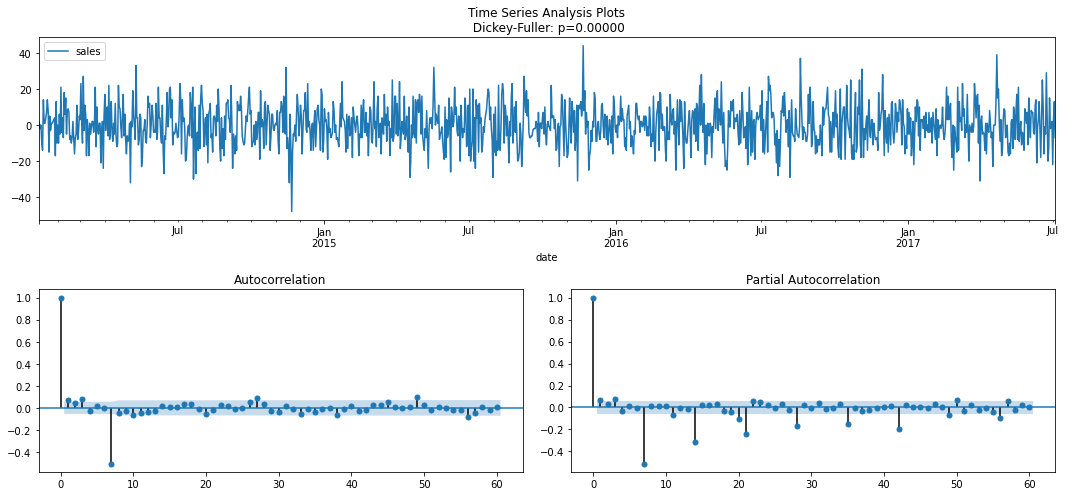

In [103]:
sales_df_train_diff2 = sales_df_train_diff1 - sales_df_train_diff1.shift(7)
test_stationarity(sales_df_train_diff2.iloc[372:], lags = 60)

*Now, our Time Series is perfectly stationary, and therefore represents something that does not depend on the time at all. We can now safely feed this series into the SARIMA model*

### SARIMA Instantiation

In [104]:
class SARIMA:
    '''
    This class calculates the best parameter value, forecasts future values on the derived set of parameters and plots the results
    
    Args:
        initial_values (iterable) -> List representing the range of the parameters in order - ps, qs, Ps, Qs (two values for each)
        series (DataFrame) -> Train timeseries of sales
        n_preds (integer) -> The number of predictions
        D (integer) -> Seasonality difference parameter
        d (integer) -> Trend difference index
        slen (integer) -> Length of the season
    
    '''
    def __init__(self, series, initial_values, n_preds = 180, D = 1, d = 7, slen = 365):
        self.series = series
        self.initial_values = initial_values
        self.n_preds = n_preds
        self.d = d
        self.D = D
        self.slen = slen
        
        
    def tune_SARIMA(self):
        '''
        This function finds the best combination of parameters for SARIMA model
        
        Returns:
            result_table (dataframe) -> The combination of Parameters along with their respective AIC values as calculated by SARIMAX
        
        '''
        
        '''
        # I have to comment out the entire tuning section because the cell was taking too long to run
        
        self.result_table = []
        ps = range(self.initial_values[0], self.initial_values[1])
        qs = range(self.initial_values[2], self.initial_values[3])
        Ps = range(self.initial_values[4], self.initial_values[5])
        Qs = range(self.initial_values[6], self.initial_values[7])
        parameters_list = list(product(ps,qs,Ps,Qs))        
        best_aic = float("inf")
        for param in tqdm_notebook(parameters_list):
            # we need try-except because on some combinations model fails to converge
            try:
                model=sm.tsa.statespace.SARIMAX(self.series.sales, order=(param[0], self.d, param[1]), 
                                                seasonal_order=(param[2], self.D, param[3], self.slen)).fit(disp=-1)
            except:
                continue
            aic = model.aic
            # saving best model, AIC and parameters
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
            results.append([param, model.aic])

        self.result_table = pd.DataFrame(results)
        self.result_table.columns = ['parameters', 'aic']
        # sorting in ascending order, the lower AIC is - the better
        self.result_table = self.result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
        p,q,P,Q = self.result_table.parameters[0]
        '''
        self.result_table = []
        self.result_table.append(7)
        self.result_table.append(7)
        self.result_table.append(2)
        self.result_table.append(1)
        # print('The best parameter values are : p - ', p, " q - ", q, 'P - ', P, ' Q - ',Q)
        
    
    def fit_SARIMA(self, test_data):
        '''
        This function fits the parameters and makes a forecast
        Also, this function can be used to determine the anomalies as well. I will havet to figure out how that can 
        be done in SARIMA modeling, but that shouldn't be too tough.
        
        Args:
            test_data (DataFrame) -> test part of the sales timeseries
        
        '''
        self.tune_SARIMA()
        self.forecast = []
        #p, q, P, Q = self.result_table.parameters[0]
        p = self.result_table[0]
        q = self.result_table[1]
        P = self.result_table[2]
        Q = self.result_table[3]
        best_model=sm.tsa.statespace.SARIMAX(self.series.sales, order=(p, self.d, q), seasonal_order=(P, self.D, Q, self.slen)).fit(disp=-1)
        print(best_model.summary())
        a_df = pd.concat(self.series, test_data, join = 'inner', axis = 0)
        forecast = best_model.predict(start = (self.slen+self.d), end = self.series.shape[0]+self.n_preds)
        self.forecast = np.array((np.NaN)*(self.slen + self.d))
        self.forecast = self.forecast.append(forecast)
        self.forecast = pd.DataFrame(self.forecast, columns = 'sales')
        self.forecast.index = pd.to_datetime(a_df.index)
        
        
    def plot_SARIMA(self, actual_values, aggregated = True):
        '''
        This function plots the results derived from SARIMA modelling. I still have to add the code for Anomalies.
        
        Args:
            actual_values (DataFrame) -> Timeseries representing sales_df, with test set included.
            aggregated (Boolean) -> Determines if we want to print the aggregated scores of values
        
        '''
        error_pred = mean_squared_error(actual_values['sales'][0-self.n_preds:], self.forecast['sales'][0-self.n_preds:])
        plt.figure(figsize = (15,7))
        plt.title("Mean Squared Error: {0:.2f}%".format(error_pred))
        if aggregated:
            agg_forecast = self.forecast.resample('W', label = 'left').sum() # Have to see if I should handle NaN values with fillna
            agg_actual_values = actual_values.resample('W', label = 'left').sum()
            plt.plot(agg_forecast, color = "g", label = "Predicted Values")
            plt.plot(agg_actual_values, color = 'b', label = "Actual Values")
        else:
            plt.plot(self.forecast, color = "g", label = "Predicted Values")
            plt.plot(actual_values, color = "b", label = "Actual Values")
        plt.axvspan(self.forecast.index[0-self.n_preds], self.forecast.index[-1], alpha = 0.4, color = 'grey')
        plt.legend(loc = 'upper left')
        plt.grid(True)
        plt.show()

In [ ]:
# This function will create the object for SARIMA model and call the plot_SARIMA function as well

initial_values = [3,8,4,8,1,3,1,2]

model_SARIMA = SARIMA(sales_df_train, initial_values, slen = 365, n_preds = 180)
model_SARIMA.fit_SARIMA(sales_df_test)
result_SARIMA = model_SARIMA.forecast
model_SARIMA.plot_SARIMA(sales_df)

## Regression Part
This part is divided into 
* Feature Generation
* Model Training
* Ploting Results

### 1) Feature Generation
We are gonna try out the following three things
* Lags of time series itself
* Adding Window Statistics (Max/Min/Mean/Variance of window)
* Day of the week, Day of the month, Day of the quarter, is it a holiday, did something special happen this day, etc


In [105]:
from datetime import date
import holidays

us_holidays = holidays.UnitedStates()

In [106]:

store_sale_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
storewise_train = store_sale_train.set_index(['store', 'item', 'date'])
store_id = 10     #Random store id
item_id = 40      # Random item id
store_item_sale_TS = create_data(storewise_train, store_id, item_id)
store_item_sale_TS_train= store_item_sale_TS.iloc[:-180]
store_item_sale_TS_test = store_item_sale_TS.iloc[-180:]
store_item_sale_df_not_TS = store_item_sale_TS.reset_index()



#### 1) Adding Date Related Features

In [107]:
store_item_sale_TS_0 = store_item_sale_TS.copy()
store_item_sale_TS_0['day_of_year'] = 0
store_item_sale_TS_0['week_of_year'] = 0
store_item_sale_TS_0['month_of_year'] = 0
store_item_sale_TS_0['day_of_month'] = 0
store_item_sale_TS_0['day_of_week'] = 0
store_item_sale_TS_0['weekend'] = 0
store_item_sale_TS_0['holiday'] = 0

for date in store_item_sale_TS_0.index:
    store_item_sale_TS_0.loc[date, 'day_of_year'] = date.dayofyear
    store_item_sale_TS_0.loc[date, 'week_of_year'] = date.weekofyear
    store_item_sale_TS_0.loc[date, 'month_of_year'] = date.month
    store_item_sale_TS_0.loc[date, 'day_of_month'] = date.day
    store_item_sale_TS_0.loc[date, 'day_of_week'] = date.dayofweek
    if date in us_holidays:
        store_item_sale_TS_0.loc[date,'holiday'] = 1
    if date.dayofweek == 6 or date.dayofweek == 5:
        store_item_sale_TS_0.loc[date,'weekend'] = 1
    
display(store_item_sale_TS_0.head())


,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday
date,,,,,,,,
2013-01-01,17,1,1,1,1,1,0,1
2013-01-02,19,2,1,1,2,2,0,0
2013-01-03,18,3,1,1,3,3,0,0
2013-01-04,21,4,1,1,4,4,0,0
2013-01-05,23,5,1,1,5,5,1,0


#### 2) Adding Lag Features

In [108]:
store_item_sale_TS_1 = store_item_sale_TS_0.copy()
for i in range(365,365+28):
    store_item_sale_TS_1["lag_{}".format(i)] = store_item_sale_TS_1.sales.shift(i)
display(store_item_sale_TS_1.head())
display(store_item_sale_TS_1.tail())

,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,...,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,17,1,1,1,1,1,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,19,2,1,1,2,2,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,18,3,1,1,3,3,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,21,4,1,1,4,4,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,23,5,1,1,5,5,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,...,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,361,52,12,27,2,0,0,24.0,21.0,...,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,38.0
2017-12-28,30,362,52,12,28,3,0,0,23.0,24.0,...,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0
2017-12-29,33,363,52,12,29,4,0,0,34.0,23.0,...,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0
2017-12-30,29,364,52,12,30,5,1,0,23.0,34.0,...,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0
2017-12-31,28,365,52,12,31,6,1,0,30.0,23.0,...,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0


#### 3) Adding Window Features (Upto one lag week)

In [109]:
month_lag_colname_list = ["lag_{}".format(i + 365) for i in range(0,28)]
week1_lag_colname_list = ["lag_{}".format(i + 365) for i in range(0,7)]
week2_lag_colname_list = ["lag_{}".format(i + 365) for i in range(7,14)]
week3_lag_colname_list = ["lag_{}".format(i + 365) for i in range(14,21)]
week4_lag_colname_list = ["lag_{}".format(i + 365) for i in range(21,28)]
fortnight_lag_colname_list = ["lag_{}".format(i + 365) for i in range(0,14)]

store_item_sale_TS_2 = store_item_sale_TS_1.copy()

store_item_sale_TS_2['month_lag_mean'] = 0
store_item_sale_TS_2['month_lag_max'] = 0
store_item_sale_TS_2['month_lag_min'] = 0
store_item_sale_TS_2['month_lag_variance'] = 0

store_item_sale_TS_2['week1_lag_mean'] = 0
store_item_sale_TS_2['week1_lag_max'] = 0
store_item_sale_TS_2['week1_lag_min'] = 0
store_item_sale_TS_2['week1_lag_variance'] = 0

# display(month_lag_colname_list)

for date in store_item_sale_TS_2.index:
    month_lag_series = store_item_sale_TS_2.loc[date, month_lag_colname_list]
    week1_lag_series = store_item_sale_TS_2.loc[date, week1_lag_colname_list]
    
    store_item_sale_TS_2.loc[date, 'month_lag_mean'] = month_lag_series.mean()
    store_item_sale_TS_2.loc[date, 'month_lag_max'] = month_lag_series.max()
    store_item_sale_TS_2.loc[date, 'month_lag_min'] = month_lag_series.min()
    store_item_sale_TS_2.loc[date, 'month_lag_variance'] = month_lag_series.var()
    
    store_item_sale_TS_2.loc[date,'week1_lag_mean'] = week1_lag_series.mean()
    store_item_sale_TS_2.loc[date,'week1_lag_max'] = week1_lag_series.max()
    store_item_sale_TS_2.loc[date,'week1_lag_min'] = week1_lag_series.min()
    store_item_sale_TS_2.loc[date,'week1_lag_variance'] = week1_lag_series.var()

display(store_item_sale_TS_2.tail(5))


# display(sale_TS.tail(10))
# display(sale_TS_1.tail(10))




,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,...,lag_391,lag_392,month_lag_mean,month_lag_max,month_lag_min,month_lag_variance,week1_lag_mean,week1_lag_max,week1_lag_min,week1_lag_variance
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,361,52,12,27,2,0,0,24.0,21.0,...,21.0,38.0,27.821429,44.0,15.0,59.337302,30.571429,44.0,21.0,93.285714
2017-12-28,30,362,52,12,28,3,0,0,23.0,24.0,...,22.0,21.0,27.285714,44.0,15.0,56.063492,30.142857,44.0,21.0,99.142857
2017-12-29,33,363,52,12,29,4,0,0,34.0,23.0,...,28.0,22.0,27.750000,44.0,15.0,56.046296,30.000000,44.0,21.0,97.666667
2017-12-30,29,364,52,12,30,5,1,0,23.0,34.0,...,27.0,28.0,27.785714,44.0,15.0,55.656085,27.000000,42.0,21.0,62.666667
2017-12-31,28,365,52,12,31,6,1,0,30.0,23.0,...,15.0,27.0,27.857143,44.0,15.0,55.830688,28.142857,42.0,21.0,58.476190


#### 4) All the window features

In [110]:
store_item_sale_TS_3 = store_item_sale_TS_2.copy()

store_item_sale_TS_3['week2_lag_mean'] = 0
store_item_sale_TS_3['week2_lag_max'] = 0
store_item_sale_TS_3['week2_lag_min'] = 0
store_item_sale_TS_3['week2_lag_variance'] = 0

store_item_sale_TS_3['week3_lag_mean'] = 0
store_item_sale_TS_3['week3_lag_max'] = 0
store_item_sale_TS_3['week3_lag_min'] = 0
store_item_sale_TS_3['week3_lag_variance'] = 0

store_item_sale_TS_3['week4_lag_mean'] = 0
store_item_sale_TS_3['week4_lag_max'] = 0
store_item_sale_TS_3['week4_lag_min'] = 0
store_item_sale_TS_3['week4_lag_variance'] = 0

# display(month_lag_colname_list)

for date in store_item_sale_TS_3.index:
    fortnight_lag_series = store_item_sale_TS_3.loc[date, fortnight_lag_colname_list]
    week2_lag_series = store_item_sale_TS_3.loc[date, week2_lag_colname_list]
    week3_lag_series = store_item_sale_TS_3.loc[date, week3_lag_colname_list]
    week4_lag_series = store_item_sale_TS_3.loc[date, week4_lag_colname_list]
    
    store_item_sale_TS_3.loc[date, 'fortnight_lag_mean'] = fortnight_lag_series.mean()
    store_item_sale_TS_3.loc[date, 'fortnight_lag_max'] = fortnight_lag_series.max()
    store_item_sale_TS_3.loc[date, 'fortnight_lag_min'] = fortnight_lag_series.min()
    store_item_sale_TS_3.loc[date, 'fortnight_lag_variance'] = fortnight_lag_series.var()
    
    store_item_sale_TS_3.loc[date,'week2_lag_mean'] = week2_lag_series.mean()
    store_item_sale_TS_3.loc[date,'week2_lag_max'] = week2_lag_series.max()
    store_item_sale_TS_3.loc[date,'week2_lag_min'] = week2_lag_series.min()
    store_item_sale_TS_3.loc[date,'week2_lag_variance'] = week2_lag_series.var()
    
    store_item_sale_TS_3.loc[date,'week3_lag_mean'] = week3_lag_series.mean()
    store_item_sale_TS_3.loc[date,'week3_lag_max'] = week3_lag_series.max()
    store_item_sale_TS_3.loc[date,'week3_lag_min'] = week3_lag_series.min()
    store_item_sale_TS_3.loc[date,'week3_lag_variance'] = week3_lag_series.var()
    
    store_item_sale_TS_3.loc[date,'week4_lag_mean'] = week4_lag_series.mean()
    store_item_sale_TS_3.loc[date,'week4_lag_max'] = week4_lag_series.max()
    store_item_sale_TS_3.loc[date,'week4_lag_min'] = week4_lag_series.min()
    store_item_sale_TS_3.loc[date,'week4_lag_variance'] = week4_lag_series.var()

display(store_item_sale_TS_3.tail())


,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,...,week3_lag_min,week3_lag_variance,week4_lag_mean,week4_lag_max,week4_lag_min,week4_lag_variance,fortnight_lag_mean,fortnight_lag_max,fortnight_lag_min,fortnight_lag_variance
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,361,52,12,27,2,0,0,24.0,21.0,...,20.0,63.238095,24.571429,38.0,15.0,53.619048,29.714286,44.0,21.0,59.604396
2017-12-28,30,362,52,12,28,3,0,0,23.0,24.0,...,20.0,64.809524,22.428571,28.0,15.0,18.619048,29.785714,44.0,21.0,58.489011
2017-12-29,33,363,52,12,29,4,0,0,34.0,23.0,...,20.0,61.952381,22.571429,28.0,15.0,18.285714,30.500000,44.0,21.0,56.730769
2017-12-30,29,364,52,12,30,5,1,0,23.0,34.0,...,20.0,64.809524,23.285714,28.0,15.0,20.904762,29.857143,44.0,21.0,60.439560
2017-12-31,28,365,52,12,31,6,1,0,30.0,23.0,...,20.0,68.142857,23.285714,28.0,15.0,20.904762,29.642857,44.0,21.0,59.631868


### 2) Model Training & Plot
We are to do the following:
1. Create Test-Train splits
2. Standardizing the scale (if it is required)
3. Training the model and producing the results
    * By Linear Regression
    * By XGBoost Regressor
4. Plot the results

#### 1. Test Train Splits

In [111]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    test_size = 0 - test_size
    X_train = X.iloc[:test_size]
    y_train = y.iloc[:test_size]
    X_test = X.iloc[test_size:]
    y_test = y.iloc[test_size:]
    
    return X_train, X_test, y_train, y_test

#### 2.   Scaling Functions

In [112]:
def standard_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #display(X_train_scaled)
    #display(X_test_scaled.shape)
    return X_train_scaled, X_test_scaled

def minmax_scaler(X_train, X_test):
    minmaxscaler = MinMaxScaler()
    X_train_scaled = minmaxscaler.fit_transform(X_train)
    X_test_scaled = minmaxscaler.transform(X_test)
    #display(X_train_minmax_scaled)
    #display(X_test_minmax_scaled.shape)
    return X_train_scaled, X_test_scaled

In [113]:
def lr_model(info_level = 2, test_size = 180, scaling_metric = 1, plot_intervals = True, plot_anomalies = False, scale = 0.2):
    '''
    This function trains the Linear Regression model on whichever level of data it is assigned and plots the results.
    
    '''
    
    if info_level == 1:
        data_df = store_item_sale_TS_1.copy()
    if info_level == 2:
        data_df = store_item_sale_TS_2.copy()
    if info_level == 3:
        data_df = store_item_sale_TS_3.copy()
    
    # First we get the data in the required format
    data_df = data_df.dropna()
    data_df_y = data_df['sales']
    data_df_X = data_df.drop(['sales'], axis = 1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(data_df_X, data_df_y, test_size = test_size)
    
    # Then we scale the data
    if scaling_metric == 1:
        X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)
    if scaling_metric == 2:
        X_train_scaled, X_test_scaled = minmax_scaler(X_train, X_test)
    
    # We now initialize the model and train it
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    prediction = lr.predict(X_test_scaled)
    #display(prediction)
    
    
    # We are now gonna plot the results along with coefficient scores
    
    predicted_df = pd.DataFrame(prediction, columns = ['sales'])
    predicted_df.index = X_test.index
    # Total error
    error_pred = float(mean_squared_error(data_df['sales'][0-test_size:],predicted_df['sales']))
    
    plt.figure(figsize = (15,7))
    plt.title("Mean Squared Error {0:.2f}".format(error_pred))
    agg_predicted = predicted_df.resample('W', label = 'left').sum()
    agg_actual = data_df.resample('W', label = 'left').sum()
    plt.plot(agg_predicted, color = "g", label = "Predicted Values")
    plt.plot(agg_actual['sales'], color = "b", label = "Actual Values")
    
    if plot_intervals:
        deviation = []
        lower_bound = []
        upper_bound = []
        agg_actual_reindexed = agg_actual.set_index(pd.Index(range(0,len(agg_actual))))
        agg_predicted_reindexed = agg_predicted.set_index(pd.Index(range(0,len(agg_predicted))))
        deviation = np.std((agg_actual_reindexed.iloc[(0-len(agg_predicted)):, 0].values, agg_predicted_reindexed['sales'].values)) 
        lower_bound = np.array(agg_predicted['sales'].values) - (error_pred + scale*deviation)
        upper_bound = np.array(agg_predicted['sales'].values) + (error_pred + scale*deviation)
        LowerBound_aggregated = pd.DataFrame(lower_bound, columns = ['sales'])
        LowerBound_aggregated.index = agg_predicted.index
        UpperBound_aggregated = pd.DataFrame(upper_bound, columns = ['sales'])
        UpperBound_aggregated.index = agg_predicted.index
        plt.plot(UpperBound_aggregated['sales'], "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
        plt.plot(LowerBound_aggregated['sales'], "r--")
        plt.fill_between(x = agg_predicted.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
        plt.axvspan(X_test.index[0], X_test.index[-1], alpha = 0.4, color = "grey")
        
    # I still have to write the code for anomalies
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()
    
    return lr



In [114]:
def XGBoost_model(info_level = 2, test_size = 180, scaling_metric = 1, plot_intervals = True, plot_anomalies = False, scale = 1.25):
    '''
    This function trains the Linear Regression model on whichever level of data it is assigned and plots the results.
    
    '''
    
    if info_level == 1:
        data_df = store_item_sale_TS_1.copy()
    if info_level == 2:
        data_df = store_item_sale_TS_2.copy()
    if info_level == 3:
        data_df = store_item_sale_TS_3.copy()
    
    # First we get the data in the required format
    data_df = data_df.dropna()
    data_df_y = data_df['sales']
    data_df_X = data_df.drop(['sales'], axis = 1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(data_df_X, data_df_y, test_size = test_size)
    
    # Then we scale the data
    if scaling_metric == 1:
        X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)
    if scaling_metric == 2:
        X_train_scaled, X_test_scaled = minmax_scaler(X_train, X_test)
    
    # We now initialize the model and train it
    xgb = XGBRegressor()
    xgb.fit(X_train_scaled, y_train)
    prediction = xgb.predict(X_test_scaled)
    #display(prediction)
    
    
    # We are now gonna plot the results along with coefficient scores
    
    predicted_df = pd.DataFrame(prediction, columns = ['sales'])
    predicted_df.index = X_test.index
    # Total error
    error_pred = float(mean_squared_error(data_df['sales'][0-test_size:],predicted_df['sales']))
    
    plt.figure(figsize = (15,7))
    plt.title("Mean Squared Error {0:.2f}".format(error_pred))
    agg_predicted = predicted_df.resample('W', label = 'left').sum()
    agg_actual = data_df.resample('W', label = 'left').sum()
    plt.plot(agg_predicted, color = "g", label = "Predicted Values")
    plt.plot(agg_actual['sales'], color = "b", label = "Actual Values")
    
    if plot_intervals:
        deviation = []
        lower_bound = []
        upper_bound = []
        agg_actual_reindexed = agg_actual.set_index(pd.Index(range(0,len(agg_actual))))
        agg_predicted_reindexed = agg_predicted.set_index(pd.Index(range(0,len(agg_predicted))))
        deviation = np.std((agg_actual_reindexed.iloc[(0-len(agg_predicted)):, 0].values, agg_predicted_reindexed['sales'].values)) 
        lower_bound = np.array(agg_predicted['sales'].values) - ((error_pred/10) + scale*deviation)
        upper_bound = np.array(agg_predicted['sales'].values) + ((error_pred/10) + scale*deviation)
        LowerBound_aggregated = pd.DataFrame(lower_bound, columns = ['sales'])
        LowerBound_aggregated.index = agg_predicted.index
        UpperBound_aggregated = pd.DataFrame(upper_bound, columns = ['sales'])
        UpperBound_aggregated.index = agg_predicted.index
        plt.plot(UpperBound_aggregated['sales'], "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
        plt.plot(LowerBound_aggregated['sales'], "r--")
        plt.fill_between(x = agg_predicted.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
        plt.axvspan(X_test.index[0], X_test.index[-1], alpha = 0.4, color = "grey")
        
    # I still have to write the code for anomalies
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()
    
    return xgb


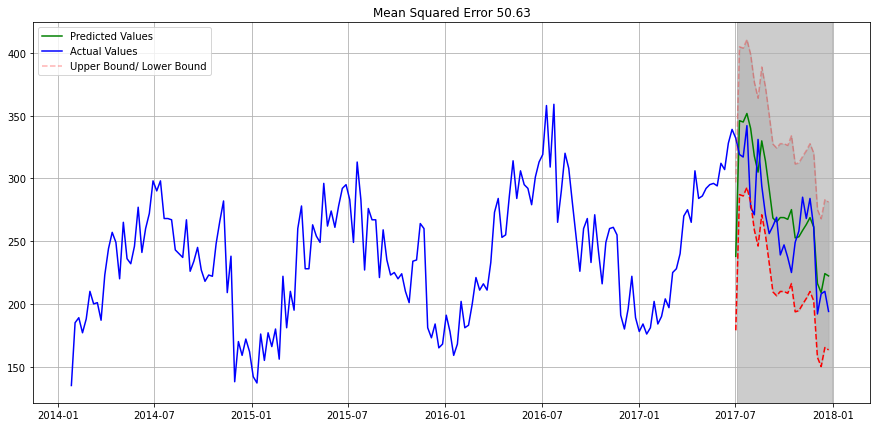

In [115]:
lr = lr_model()

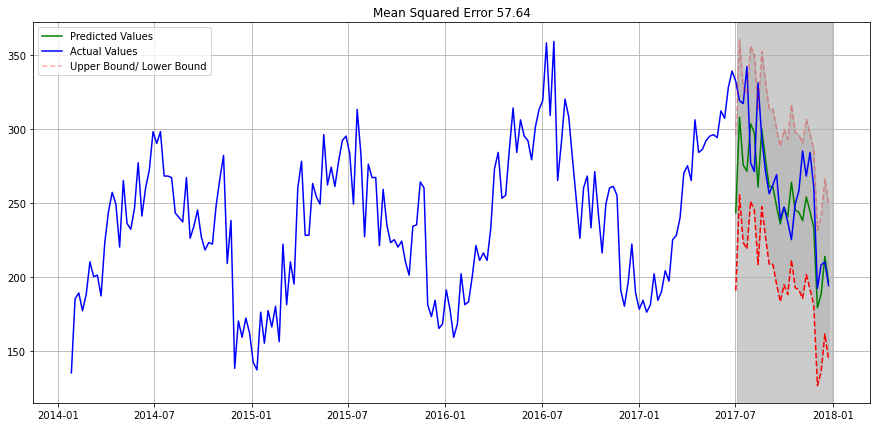

In [116]:
xgb = XGBoost_model()

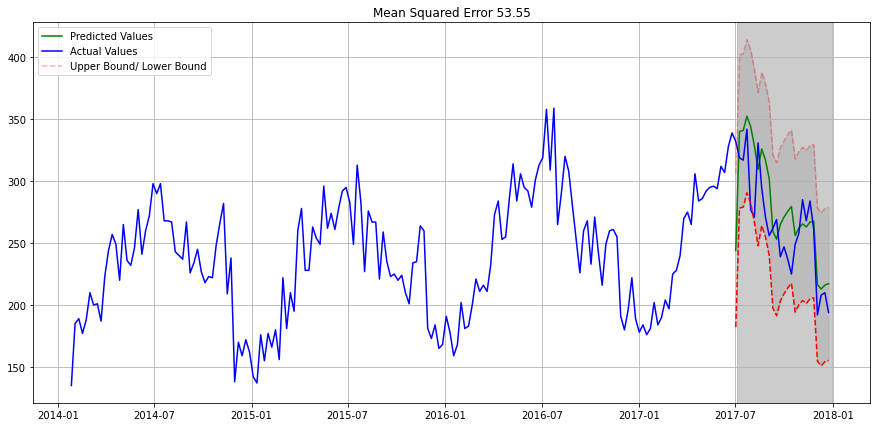

In [117]:
lr = lr_model(info_level = 3)

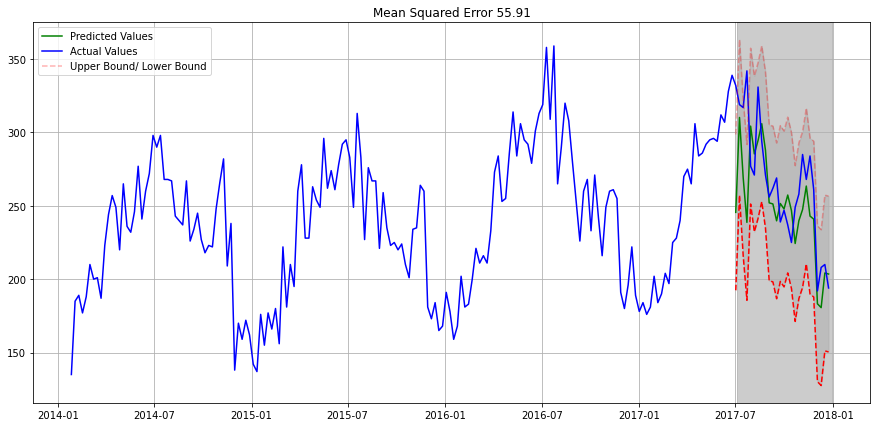

In [118]:
xgb = XGBoost_model(info_level = 3)

## LSTM Approach
Here we are gonna perform the following steps:
1. Create the dataset
2. Create the test train split along with making the data ready for LSTM.
3. Modelling Approaches (Give reasons for how different models could influence the results)
4. Plot the results

### Questions to be Answered :-
1. Is there any difference in feeding lag data in form of features (by adding columns containing the lag information, and using window_size = 1) or by feeding the model with "windows of time" using 'history_size' feature?
2. Should the 'history_size' parameter be greater than the 'target_size' parameter (in case of multistep predictions). Either way, what's the acceptable approach to identifying both these values for Time Series forecasting? Also, why do we need to defining 'history_size' and 'window_size' in the first place, how does it relate to the workings of LSTM?
3. (Optional) Is there a reasonable way of using one step predictions to be used as lag features in upcoming step predictions, instead of having to make the model learn to make multi step predictions (of size 'target_size'), as this task of multi-step predictions comes with accompanying data size requirments.
4. Can the data from all the series from all the stores and items be used (since all of it seems to follow a pattern)? What is a reasonable standard for this? How to manage the time scale of each subsequent time series (if that would even be a problem, since we are not actually feeding the model with dates)?
5. What are the reasonable values for the number of 'cells' or 'units' in LSTM? number of epochs? Number of layers? Droput value? The shape of input and output? How to infer them and initialize them in Keras? 
6. Can the lag features from a year ago be used in the batch formalization of input for LSTM (if so, how)? How are the results influenced by this in comparison to the ones produced by immediate lag values? What is a reasonable 'ratio' of the data in comparison to seasons, such that seasonal lag values can be safely used?
7. How would stacking recurrent layers effect the results? How does using bi-directional RNNs effect the output?
8. How does the shuffle function on 'from_tensor_slices' effect the ouput. I have to try both ways, with and without it.
___
8. How to handle seasonality & trend in data?
9. How does LSTM clustering work? Is it any good for our case? When should it be applied?
10. How to use CNNs along with LSTM for forecasting problems? When are they preferred? List the scenarios where they might be really effective (more so than general LSTM)
11. How does LSTNet work and what are its ideal use case scenarios?



In [119]:
store_sale_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
storewise_train = store_sale_train.set_index(['store', 'item', 'date'])
store_id = 10     #Random store id
item_id = 40      # Random item id
store_item_sale_TS = create_data(storewise_train, store_id, item_id)
store_item_sale_TS_train= store_item_sale_TS.iloc[:-180]
store_item_sale_TS_test = store_item_sale_TS.iloc[-180:]
store_item_sale_df_not_TS = store_item_sale_TS.reset_index()


### 1. Create Dataset
I am gonna try the following datasets
1. The simple time series of sales of a single store, to be used:
     * With window size of 50 containing immediate lag values.
     * With window size of 60 containing 30 immediate lag values and 30 year prior lag values.
___    
2. A simple 50 lag TS data (added as features/columns), to be used with windows of size 1, such that:
    * Data belongs to 50 immediate lags.
    * Data belongs to 30 immediate lags and 30 lags from the year prior
___    
3. Create a time series with seasonality and trend components removed (using PACF plots). Try it on whichever (of the above two) approach produce the best result. Keep a note here, that the window size is (most probably) gonna be smaller and should be set to be equal to the largest prominent lag in PACF plot (after removing seasonality and trend). Also, special point of consideration here - I will have to inverse the results produced by adding the lag values that I have removed to get the plot of results in the desired format.
___
4. Create a dataset for all the stores and items. It will: (add the store and item values as features). Make the predictions using whichever approach (of the above three) produced the best results. 
    * Add the store and item values as features
    * Employ whichever combination of the above three produces the best results.
    * Produce the combination of test and train splits on the basis of whichever store_id and item_id is passed into the test_train_split function.
___     
5. (Optional) If I end up trying the clustered LSTM (for all the stores and items), I will have to create data from each store and item and structure it according to the model requirements


##### 1. The simple time series of sales of a single store

In [120]:
store_item_sale_TS_1_1 = store_item_sale_TS.copy()
display(store_item_sale_TS_1_1.head())
display(store_item_sale_TS_1_1.tail())


# The second part of this approach to dataset will be implemented in the test train split function

,sales
date,
2013-01-01,17
2013-01-02,19
2013-01-03,18
2013-01-04,21
2013-01-05,23


,sales
date,
2017-12-27,34
2017-12-28,30
2017-12-29,33
2017-12-30,29
2017-12-31,28


##### 2. A simple 50 lag TS data (added as features/columns), to be used with windows of size 1

In [121]:
# Data belongs to 50 immediate lags.
store_item_sale_TS_2_1 = store_item_sale_TS.copy()
for i in range(1,50):
    store_item_sale_TS_2_1["lag_{}".format(i)] = store_item_sale_TS_2_1.sales.shift(i)
display(store_item_sale_TS_2_1.head())
display(store_item_sale_TS_2_1.tail())

# Data belongs to 30 immediate lags and 30 lags from the year prior
store_item_sale_TS_2_2 = store_item_sale_TS.copy()
for i in range(1, 30):
    store_item_sale_TS_2_2["lag_{}".format(i)] = store_item_sale_TS_2_2.sales.shift(i)
for i in range(365, 365+30):
    store_item_sale_TS_2_2["lag_{}".format(i)] = store_item_sale_TS_2_2.sales.shift(i)
display(store_item_sale_TS_2_2.head())
display(store_item_sale_TS_2_2.tail())


,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,19,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,18,19.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,21,18.0,19.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,23,21.0,18.0,19.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,21.0,19.0,24.0,34.0,40.0,35.0,35.0,21.0,21.0,...,38.0,44.0,22.0,46.0,43.0,57.0,37.0,44.0,40.0,38.0
2017-12-28,30,34.0,21.0,19.0,24.0,34.0,40.0,35.0,35.0,21.0,...,38.0,38.0,44.0,22.0,46.0,43.0,57.0,37.0,44.0,40.0
2017-12-29,33,30.0,34.0,21.0,19.0,24.0,34.0,40.0,35.0,35.0,...,37.0,38.0,38.0,44.0,22.0,46.0,43.0,57.0,37.0,44.0
2017-12-30,29,33.0,30.0,34.0,21.0,19.0,24.0,34.0,40.0,35.0,...,36.0,37.0,38.0,38.0,44.0,22.0,46.0,43.0,57.0,37.0
2017-12-31,28,29.0,33.0,30.0,34.0,21.0,19.0,24.0,34.0,40.0,...,33.0,36.0,37.0,38.0,38.0,44.0,22.0,46.0,43.0,57.0


,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,lag_393,lag_394
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,19,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,18,19.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,21,18.0,19.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,23,21.0,18.0,19.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,lag_393,lag_394
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,21.0,19.0,24.0,34.0,40.0,35.0,35.0,21.0,21.0,...,23.0,21.0,15.0,27.0,28.0,22.0,21.0,38.0,35.0,20.0
2017-12-28,30,34.0,21.0,19.0,24.0,34.0,40.0,35.0,35.0,21.0,...,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,38.0,35.0
2017-12-29,33,30.0,34.0,21.0,19.0,24.0,34.0,40.0,35.0,35.0,...,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,38.0
2017-12-30,29,33.0,30.0,34.0,21.0,19.0,24.0,34.0,40.0,35.0,...,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0
2017-12-31,28,29.0,33.0,30.0,34.0,21.0,19.0,24.0,34.0,40.0,...,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0


##### 3. Time series with seasonality and trend components removed (using PACF plots)

In [122]:
# Here we will try to remove non stationarity by removing seasonality. We can see the season is an year -> 365 days.
store_item_sale_TS_3_1 = store_item_sale_TS.copy()
store_item_sale_TS_3_1 = store_item_sale_TS_3_1 - store_item_sale_TS_3_1.shift(365)
#test_stationarity(store_item_sale_TS_3_1.iloc[365:], lags = 60)

store_item_sale_TS_3_1 = store_item_sale_TS_3_1 - store_item_sale_TS_3_1.shift(7)
#test_stationarity(store_item_sale_TS_3_1.iloc[372:], lags = 60)
display(store_item_sale_TS_3_1.head())
display(store_item_sale_TS_3_1.tail())


,sales
date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN


,sales
date,
2017-12-27,4.0
2017-12-28,-2.0
2017-12-29,-6.0
2017-12-30,16.0
2017-12-31,-4.0


##### 4. Dataset for all the stores and items

In [ ]:
sales_df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
sales_df_4_1 = sales_df.set_index(['date'])
sales_df_4_1.index = pd.to_datetime(sales_df_4_1.index)
# Further steps will create the dataframe in accordance to the best approached inferred from results of earlier approaches




### 2. Creating Test/Train Splits
Here we are gonna break our data into test train splits and store it in the format that can be fed into the LSTM model.

In [123]:
def standard_scaler_LSTM(X_train, X_test):
    X_train_scaled = []
    X_test_scaled = []
    scaler = StandardScaler()
    print("Shape of X_train is", X_train.shape)
    print("Shape of X_test is", X_test.shape)
    for i in range(X_train.shape[0]):
        X_train_scaled.append(scaler.fit_transform(X_train[i]).tolist())
    for j in range(X_test.shape[0]):
        X_test_scaled.append(scaler.transform(X_test[j]).tolist())
    #display(X_train_scaled)
    #display(X_test_scaled.shape)
    return np.array(X_train_scaled), np.array(X_test_scaled)


In [ ]:
def multivariate_data(dataset, target, end_index, start_index = 0, history_size = 50, target_size = 180, step = 1, single_step=False, seasonal_lag = False, slen = 365, seasonal_history_size = 30):
    '''
    This function converts the given data into batches that can be fed into the LSTM model
    
    
    '''
    data = []
    label_values = []
    if seasonal_lag:
        start_index = start_index + slen + seasonal_history_size
    else:
        start_index = start_index + history_size
        
    print("Start Index is ", start_index)
    
    if end_index is None:
        end_index = dataset.shape[0] - target_size
    
    print("End index is ", end_index)

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if seasonal_lag:
            indices = range(i-slen-seasonal_history_size, i-slen, step)
            data.append(dataset[indices])

        if single_step:
            label_values.append(target[i+target_size])
        else:
            label_values.append(target[i:i+target_size])
    #print("Shape of label values is ", label_values.shape)
    return np.array(data), np.array(label_values)

In [ ]:

def create_data_for_LSTM(dataset, history_size, test_size = 180, seasonal_lag = False, seasonal_history_size = 30):
    '''
    This function divides the data into test and train parts by calling the multvariate_data function. It then forms
    
    
    
    '''
    STEP = 1
    BATCH_SIZE = 50
    if seasonal_lag:
        test_start_point = dataset.shape[0] - 2*test_size - slen - seasonal_history_size
    else:
        test_start_point = dataset.shape[0] - 2*test_size - history_size
    TRAIN_SPLIT = dataset.shape[0] - test_size 
    #display(TRAIN_SPLIT)
    #display(test_start_point)
    #display(dataset[:,0].shape)
    print("Following part happens for train data generation")
    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], start_index = 0, end_index = TRAIN_SPLIT, history_size = history_size, seasonal_lag = seasonal_lag,seasonal_history_size = seasonal_history_size, target_size = test_size, step = STEP)
    print("Following part happens for test data generation")
    x_test_multi, y_test_multi = multivariate_data(dataset, dataset[:, 0], start_index = test_start_point, end_index = None, history_size = history_size, seasonal_lag = seasonal_lag, seasonal_history_size = seasonal_history_size, target_size = test_size, step = STEP)
    print ('Single window of past history : {}'.format(x_train_multi[0].shape))
    print('Shape of x_train_multi is ', x_train_multi.shape)
    print('Shape of x_test_multi is ', x_test_multi.shape)
    print('Shape of y_train_multi is ', y_train_multi.shape)
    print('Shape of y_test_multi is ', y_test_multi.shape)
    
    x_train_multi_scaled, x_test_multi_scaled = standard_scaler_LSTM(x_train_multi, x_test_multi)
    
    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi_scaled, y_train_multi))
    #train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

    test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi_scaled, y_test_multi))
    #test_data_multi = test_data_multi.batch(BATCH_SIZE).repeat()
    test_data_multi = test_data_multi.batch(BATCH_SIZE).repeat()
    
    return x_train_multi_scaled, train_data_multi, test_data_multi




### 3. Modelling Approaches
Create the following iterations of models (over the vanilla LSTM) and compare the results:
1. Add extra units.
2. Add extra LSTM layers (remember to make sure they are spitting out sequences that can be fed into the next LSTM layer).
3. Adjust the dropout rate, notice how it effects the output
4. Enable Bi-Directional LSTM.

In this function I will first have to decide on the data to be used, then scale it, then convert it into numpy array, then pass it on to "test_train_split" part to produce the data in form of batches/tensors that can be fed into the LSTM model. Then we instantiate the model itself and train upon it.

##### Model Implementation

In [ ]:
def LSTM_model_1(dataset_type = 1, test_size = 180, plot_intervals = True, plot_anomalies = False, scale = 1.25):
    '''
    This function defines the sequential LSTM model and implements it on the data defined by the "dataset_type" passed to this function
    
    
    '''
    
    if dataset_type == 1:
        data_df1 = store_item_sale_TS_1_1.copy()
        data_df = store_item_sale_TS_1_1.copy()
        data_df1 = data_df1.dropna()
        dataset = data_df1.values
        x_train_multi_scaled, train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 50, test_size = 180, seasonal_lag = False, seasonal_history_size = 30)
        
    if dataset_type == 2:
        data_df1 = store_item_sale_TS_1_1.copy()
        data_df = store_item_sale_TS_1_1.copy()
        data_df1 = data_df1.dropna()
        dataset = data_df1.values
        x_train_multi_scaled, train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 30, test_size = 180, seasonal_lag = True, seasonal_history_size = 30)
        
    if dataset_type == 3:
        data_df1 = store_item_sale_TS_2_1.copy()
        data_df = store_item_sale_TS_2_1.copy()
        data_df1 = data_df1.dropna()
        dataset = data_df1.values
        x_train_multi_scaled, train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 1, test_size = 180, seasonal_lag = False, seasonal_history_size = 30)
        
    if dataset_type == 4:
        data_df1 = store_item_sale_TS_2_2.copy()
        data_df = store_item_sale_TS_2_2.copy()
        data_df1 = data_df1.dropna()
        dataset = data_df1.values
        x_train_multi_scaled, train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 1, test_size = 180, seasonal_lag = False, seasonal_history_size = 30)
        
    if dataset_type == 5:
        data_df1 = store_item_sale_TS_3_1.copy()
        data_df = store_item_sale_TS_3_1.copy()
        data_df1 = data_df1.dropna()
        dataset = data_df1.values
        x_train_multi_scaled, train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 30, test_size = 180, seasonal_lag = True, seasonal_history_size = 30) # This part is to be decided after evaluating the results derived from above iterations
        
    EPOCHS = 50
    model_1 = tf.keras.models.Sequential()
    model_1.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi_scaled.shape[-2:])) #Still have to get the x_train_multi values returned from the earlier functions
    model_1.add(tf.keras.layers.LSTM(16, activation='relu'))
    model_1.add(tf.keras.layers.Dense(180))

    model_1.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')
    
    for x, y in test_data_multi.take(1):
        print (model_1.predict(x).shape)
        
    model_1_history = model_1.fit(train_data_multi, epochs=EPOCHS, validation_data=test_data_multi, validation_steps=50, steps_per_epoch = 200)
    
    
    
    for x, y in test_data_multi.take(1):
        prediction = model_1.predict(x)[0]
    
    
    
    # Now we move to the plotting part
    
    predicted_df = pd.DataFrame(prediction, columns = ['sales'])
    predicted_df.index = store_item_sale_TS_test.index # still have to figure out this indexing part
    # Total error
    error_pred = float(mean_squared_error(data_df['sales'][0-test_size:],predicted_df['sales']))
    
    plt.figure(figsize = (15,7))
    plt.title("Mean Squared Error {0:.2f}".format(error_pred))
    agg_predicted = predicted_df.resample('W', label = 'left').sum()
    agg_actual = data_df.resample('W', label = 'left').sum()
    plt.plot(agg_predicted, color = "g", label = "Predicted Values")
    plt.plot(agg_actual['sales'], color = "b", label = "Actual Values")
    
    if plot_intervals:
        deviation = []
        lower_bound = []
        upper_bound = []
        agg_actual_reindexed = agg_actual.set_index(pd.Index(range(0,len(agg_actual))))
        agg_predicted_reindexed = agg_predicted.set_index(pd.Index(range(0,len(agg_predicted))))
        deviation = np.std((agg_actual_reindexed.iloc[(0-len(agg_predicted)):, 0].values, agg_predicted_reindexed['sales'].values)) 
        lower_bound = np.array(agg_predicted['sales'].values) - ((error_pred/10) + scale*deviation)
        upper_bound = np.array(agg_predicted['sales'].values) + ((error_pred/10) + scale*deviation)
        LowerBound_aggregated = pd.DataFrame(lower_bound, columns = ['sales'])
        LowerBound_aggregated.index = agg_predicted.index
        UpperBound_aggregated = pd.DataFrame(upper_bound, columns = ['sales'])
        UpperBound_aggregated.index = agg_predicted.index
        l1 = len(agg_predicted)
        
        anomalies_aggregated = np.array([np.NaN]*l1) # Have to figure out l1
        anomalies_aggregated = pd.DataFrame(anomalies_aggregated)
        anomalies_aggregated.index = agg_predicted.index
        drop_list1 = []
        for j in range(len(anomalies_aggregated)):
            if agg_actual.values[j][0] < LowerBound_aggregated.values[j][0]:
                anomalies_aggregated.iloc[j] = agg_actual.values[j][0]
            if agg_actual.values[j][0] > UpperBound_aggregated.values[j][0]:
                anomalies_aggregated.iloc[j] = agg_actual.values[j][0]
            else:
                drop_list1.append(j)
        anomalies_aggregated.drop(anomalies_aggregated.index[drop_list1], axis = 0, inplace = True)
        
        
        plt.plot(UpperBound_aggregated['sales'], "r--", alpha = 0.7, label = "Upper Bound/ Lower Bound")
        plt.plot(LowerBound_aggregated['sales'], "r--", alpha = 0.7)
        plt.plot(anomalies_aggregated, "o", color = "r", markersize = 5, label = "Anomalies")
        plt.fill_between(x = agg_predicted.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
        plt.axvspan(predicted_df.index[0], predicted_df.index[-1], alpha = 0.4, color = "grey")
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()
    
    return model_1
    


In [ ]:
model1 = LSTM_model_1()

##### Adding extra units and removing one of the LSTM layers

In [ ]:
def LSTM_model_2(dataset_type = 1):
    '''
    This function defines the sequential LSTM model and implements it on the data defined by the "dataset_type" passed to this function
    
    
    '''
    
    if dataset_type == 1:
        data_df = store_item_sale_TS_1_1.copy()
        dataset = data_df.values
        train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 50, test_size = 180, seasonal_lag = False, seasonal_history_size = 30)
        
    if dataset_type == 2:
        data_df = store_item_sale_TS_1_1.copy()
        dataset = data_df.values
        train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 30, test_size = 180, seasonal_lag = True, seasonal_history_size = 30)
        
    if dataset_type == 3:
        data_df = store_item_sale_TS_2_1.copy()
        dataset = data_df.values
        train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 1, test_size = 180, seasonal_lag = False, seasonal_history_size = 30)
        
    if dataset_type == 4:
        data_df = store_item_sale_TS_2_2.copy()
        dataset = data_df.values
        train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 1, test_size = 180, seasonal_lag = False, seasonal_history_size = 30)
        
    if dataset_type == 5:
        data_df = store_item_sale_TS_3_1.copy()
        dataset = data_df.values
        train_data_multi, test_data_multi = create_data_for_LSTM(dataset, history_size = 30, test_size = 180, seasonal_lag = True, seasonal_history_size = 30) # This part is to be decided after evaluating the results derived from above iterations
        
    EPOCHS = 50
    model_2 = tf.keras.models.Sequential()
    model_2.add(tf.keras.layers.LSTM(75, activation='relu', input_shape=x_train_multi.shape[-2:])) #Still have to get the x_train_multi values returned from the earlier functions
    model_2.add(tf.keras.layers.Dense(72))

    model_2.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')
    
    for x, y in test_data_multi.take(1):
        print (model_2.predict(x).shape)
        
    model_2_history = model_2.fit(train_data_multi, epochs=EPOCHS, validation_data=test_data_multi, validation_steps=50)
    
    for x, y in test_data_multi.take(1):
        prediction = model_1.predict(x)[0]
    
    
    
    # Now we move to the plotting part
    
    predicted_df = pd.DataFrame(prediction, columns = ['sales'])
    predicted_df.index = X_test.index # Still have to figure out this indexing part
    # Total error
    error_pred = float(mean_squared_error(data_df['sales'][0-test_size:],predicted_df['sales']))
    
    plt.figure(figsize = (15,7))
    plt.title("Mean Squared Error {0:.2f}".format(error_pred))
    agg_predicted = predicted_df.resample('W', label = 'left').sum()
    agg_actual = data_df.resample('W', label = 'left').sum()
    plt.plot(agg_predicted, color = "g", label = "Predicted Values")
    plt.plot(agg_actual['sales'], color = "b", label = "Actual Values")
    
    if plot_intervals:
        deviation = []
        lower_bound = []
        upper_bound = []
        agg_actual_reindexed = agg_actual.set_index(pd.Index(range(0,len(agg_actual))))
        agg_predicted_reindexed = agg_predicted.set_index(pd.Index(range(0,len(agg_predicted))))
        deviation = np.std((agg_actual_reindexed.iloc[(0-len(agg_predicted)):, 0].values, agg_predicted_reindexed['sales'].values)) 
        lower_bound = np.array(agg_predicted['sales'].values) - ((error_pred/10) + scale*deviation)
        upper_bound = np.array(agg_predicted['sales'].values) + ((error_pred/10) + scale*deviation)
        LowerBound_aggregated = pd.DataFrame(lower_bound, columns = ['sales'])
        LowerBound_aggregated.index = agg_predicted.index
        UpperBound_aggregated = pd.DataFrame(upper_bound, columns = ['sales'])
        UpperBound_aggregated.index = agg_predicted.index
        plt.plot(UpperBound_aggregated['sales'], "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
        plt.plot(LowerBound_aggregated['sales'], "r--")
        plt.fill_between(x = agg_predicted.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
        plt.axvspan(X_test.index[0], X_test.index[-1], alpha = 0.4, color = "grey")
        
    # I still have to write the code for anomalies
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()
    
